In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import talib
from scipy.stats import linregress
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from check_mean_reversion import check_mean_reversion, plot_autocorrelation_mr, plot_adx_mr, compute_indicators_mean_reversion, plot_price_with_sma_crosses
from check_trend_following import check_trend_following, plot_autocorrelation, plot_adx, plot_sma_trend, compute_indicators
from calendar_analysis import analyze_calendar_effects
from check_outliers import detect_outliers, plot_outliers
from pattern_up_down import analyze_up_down
from trading_strategy_season import run_strategy, plot_trades, plot_trades_by_year
import math



## Khởi tạo ban đầu

In [22]:
# Đường dẫn folder chứa dữ liệu
base_folder = r'C:\\Users\\Dinh Binh An\\OneDrive\\Dai_hoc\\toan_tai_chinh\\giua_ki\\Data'

# Đường dẫn file
file_path = os.path.join(base_folder, 'KO.csv')

df_main = pd.read_csv(file_path, parse_dates=['Date'])
df_main = df_main.sort_values('Date').reset_index(drop=True)

print(f"Data shape: {df_main.shape}")
print(f"Date range: {df_main['Date'].min()} to {df_main['Date'].max()}")

Data shape: (2514, 8)
Date range: 2015-10-01 00:00:00-04:00 to 2025-09-30 00:00:00-04:00


In [23]:
# Chia dữ liệu 70% train và 30% validation
split_index = int(len(df_main) * 0.7)

# Dữ liệu cho EDA & huấn luyện
df = df_main[:split_index].copy()

# Dữ liệu cho validation
df_val = df_main[split_index:].copy()

print(f"Total data: {len(df)} ngày")
print(f"EDA data: {len(df)} ngày ({len(df)/len(df_main)*100:.1f}%)")
print(f"Backtest data: {len(df_val)} ngày ({len(df_val)/len(df_main)*100:.1f}%)")
print(f"\nEDA date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Backtest date range: {df_val['Date'].min()} to {df_val['Date'].max()}")


Total data: 1759 ngày
EDA data: 1759 ngày (70.0%)
Backtest data: 755 ngày (30.0%)

EDA date range: 2015-10-01 00:00:00-04:00 to 2022-09-26 00:00:00-04:00
Backtest date range: 2022-09-27 00:00:00-04:00 to 2025-09-30 00:00:00-04:00


# Khám phá dữ liệu

In [24]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-10-01 00:00:00-04:00,29.149118,29.330303,28.699776,28.844725,19606600,0.0,0.0
1,2015-10-02 00:00:00-04:00,28.670776,29.272310,28.525827,29.272310,15537300,0.0,0.0
2,2015-10-05 00:00:00-04:00,29.315814,29.750659,29.301319,29.721668,15664000,0.0,0.0
3,2015-10-06 00:00:00-04:00,29.743400,29.960822,29.663678,29.685419,14579400,0.0,0.0
4,2015-10-07 00:00:00-04:00,29.815875,30.156505,29.786885,30.091278,14329700,0.0,0.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1759 non-null   object 
 1   Open          1759 non-null   float64
 2   High          1759 non-null   float64
 3   Low           1759 non-null   float64
 4   Close         1759 non-null   float64
 5   Volume        1759 non-null   int64  
 6   Dividends     1759 non-null   float64
 7   Stock Splits  1759 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 110.1+ KB


## Kiểm tra & xử lý dữ liệu

In [26]:
# Kiểm tra missing data
df.isna().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [27]:
# kiểm tra dữ liệu trùng lặp
df.duplicated().sum()

np.int64(0)

In [28]:
# Chuyển cột Date sang kiểu Datetime
df['Date'] = pd.to_datetime(df['Date'], utc = True)

Số outlier: 3
Danh sách các outlier: 
| Date       |    Open |    High |     Low |   Close |   Volume |   Dividends |   Stock Splits |     return | is_outlier   |   qq_deviation |
|:-----------|--------:|--------:|--------:|--------:|---------:|------------:|---------------:|-----------:|:-------------|---------------:|
| 2019-02-14 | 37.6557 | 37.8653 | 36.6881 | 36.7606 | 58905400 |           0 |              0 | -0.084354  | True         |        4.02267 |
| 2020-03-12 | 40.3795 | 41.5358 | 38.8405 | 39.2315 | 31913100 |           0 |              0 | -0.0967244 | True         |        4.58322 |
| 2020-03-20 | 35.2034 | 35.3041 | 31.4775 | 32.1404 | 51513500 |           0 |              0 | -0.084389  | True         |        3.87259 |


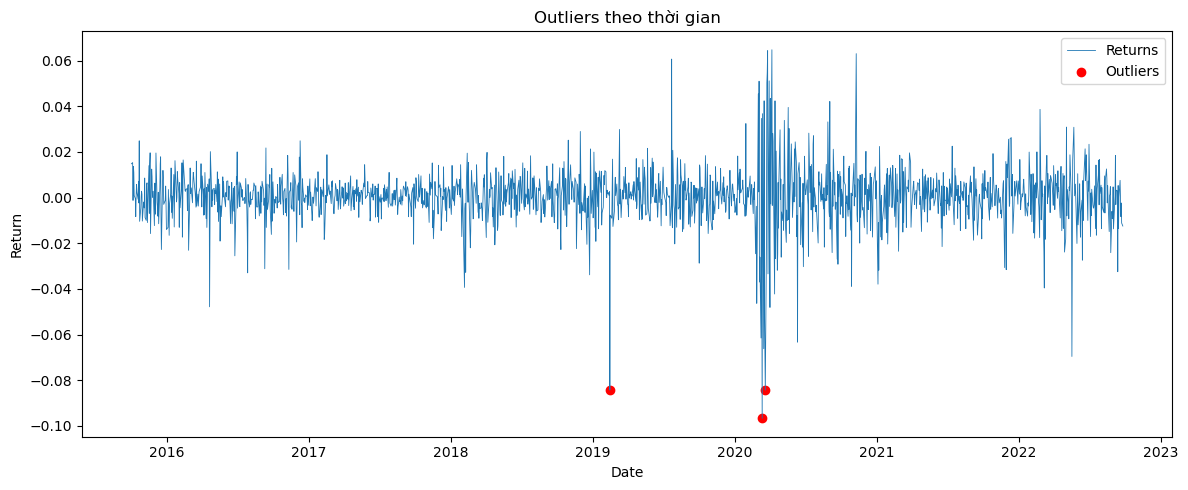

In [29]:
# Kiểm tra outlier
result = detect_outliers(df, price_col='Close', threshold=3)

print("Số outlier:", result['outliers'].shape[0])
print("Danh sách các outlier: ")
print(result['outliers'].to_markdown())

# Trực quan các outlier
plot_outliers(result['df'])




**Nhận xét**:

- Dựa trên phương pháp sử dụng phương pháp dựa trên QQ-plot (Quantile-Quantile plot) ta phát hiện được 3 outlier giá giảm mạnh trong ngày, ở các ngày lần lượt là: 2019-02-14, 2020-03-12, 2020-03-20.
  
- Đặc biệt ở đây có đến 2 outlier là thuộc đầu năm 2020, nguyên nhân có thể là do yếu tố bên ngoài, cụ thể đầu năm 2020 là giai đoạn đầu đại dịch COVID-19, nên các thị trường chứng khoáng toàn cầu đều giảm mạnh, dẫn đến giá cổ phiếu Coca-cola cũng giảm mạnh theo.
  
- Ở đây ta không xử lý các outlier này vì chúng là kết quả của các sự kiện thực tế như đại dịch hay tin xấu của công ty, giữ lại có thể giúp ta phân tích chính xác rủi ro cực đoan và hành vi thị trường.


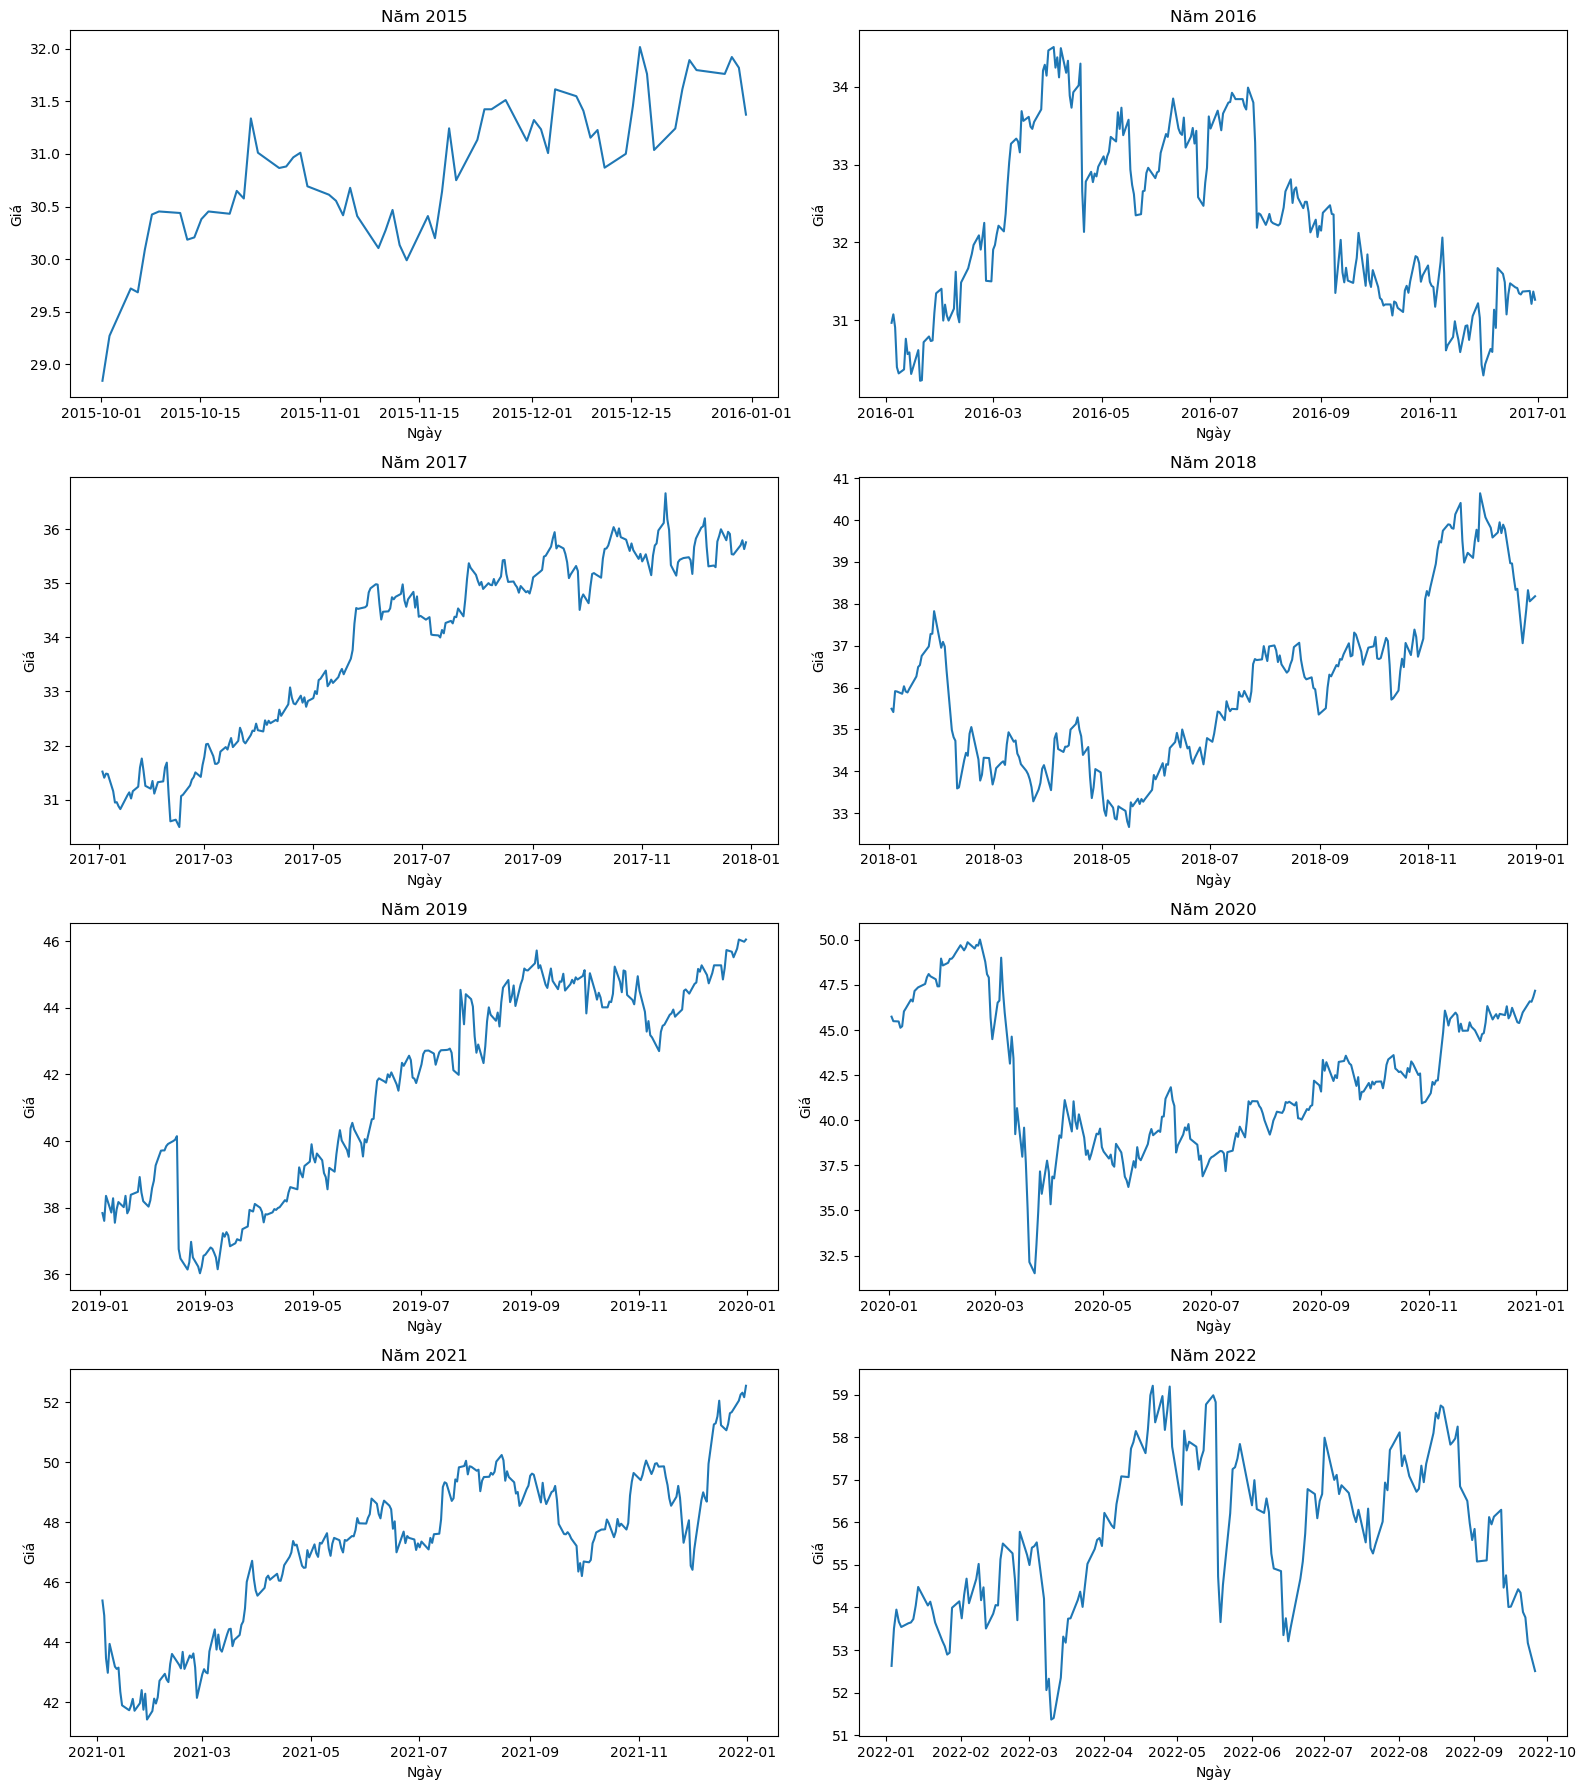

In [30]:
# Giá tăng theo từng năm

years = sorted(df['Date'].dt.year.unique())

num_years = len(years)
cols = 2
rows = math.ceil(num_years / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, 18), sharex=False, sharey=False)
axes = axes.flatten()  # đơn giản hóa truy cập

for idx, year in enumerate(years):
    df_year = df[df['Date'].dt.year == year]
    ax = axes[idx]

    ax.plot(df_year['Date'], df_year['Close'])
    ax.set_title(f"Năm {year}", fontsize=12)
    ax.set_xlabel("Ngày")
    ax.set_ylabel("Giá")

plt.tight_layout()
plt.show()

## Kiểm tra cổ phiếu có pattern trend-following 

**Các điều kiện kiểm tra**:

- AutoCorrelation > 0 (1)
  
- median ADX > 25 (2)

- Tỷ lệ thời gian giá trên/dưới SMA trung hạn (SMA 50) (3)

**Giải thích**:

- (1): Nếu cổ phiếu có pattern trend-following thì nếu giá ngày trước giá tăng/giảm thì ngày sau có xu hướng tiếp tục theo cùng hướng. Nên AutoCorrelation  > 0 thể hiện tương quan dương giữa returns tại thời điểm t và t+1..
  
- (2): ADX là dùng để đo độ mạnh xu hướng, không xét tăng hay giảm. Giá biến động nhiều mà không có xu hướng rõ thì chiến lược trend-following sẽ kém hiệu quả. ADX > 25 là ngưỡng thường được dùng để kiểm tra "trend mạnh".

- (3): Nếu cổ phiếu thực sự có trend ổn định thì phần lớn giá sẽ nằm trên/dưới đường SMA trung hạn. Tức là giá nó tăng/giảm bền vững ít bị nhiễu.


autocorr: -0.034375013810489276
adx_median: 19.86539755934004
pct_close_above_SMA50: 0.6350198976691301
pct_close_below_SMA50: 0.33712336554860717
SMA50_slope: 0.013963004066399049
trend_direction: up


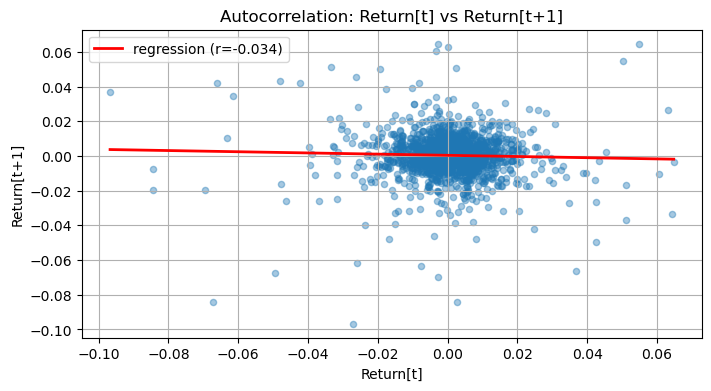

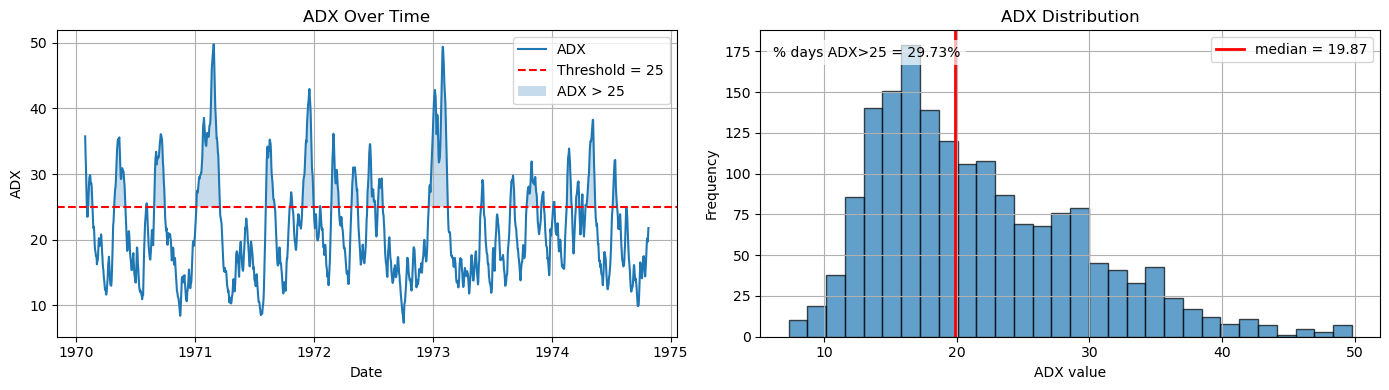

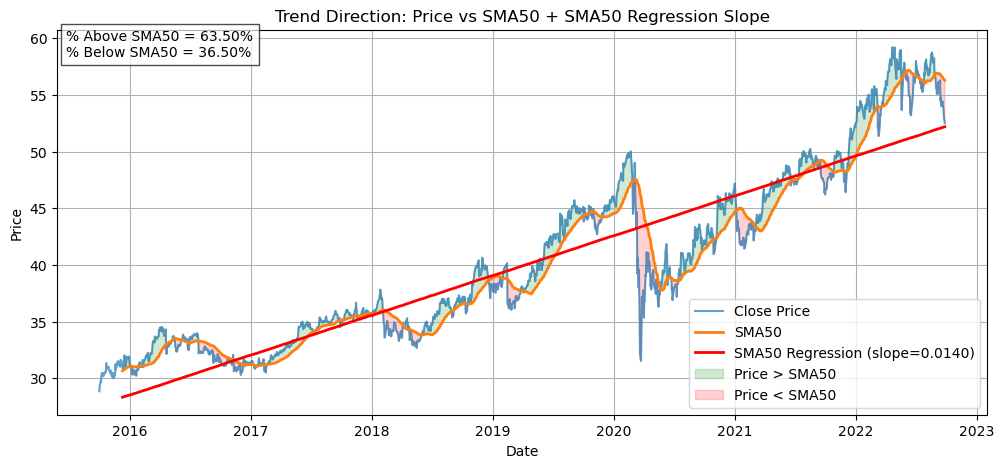

In [31]:
# Kiểm tra cổ phiếu có pattern trend-following không
results = check_trend_following(df)

for k, v in results.items():
    print(f"{k}: {v}")

# Trực quan hóa
plot_autocorrelation(df)
plot_adx(df)
plot_sma_trend(df)



**Nhận xét**:

+ autocorr = -0.03437 < 0 : giá không có xu hương duy trì đà của nó
  
+ adx_median = 19.86539 < 25 :  Xu hướng không đủ mạnh

+ SMA50_slope:  0.01396 => Có xu hướng trung bình đang đi lên nhưng mà yếu

+ pct_close_above_SMA50 = 0.63501 => chưa đủ nhiều

+ pct_close_below_SMA50 = 0.33712

**Kết luận**: 

Cổ phiếu chưa đủ cơ sở để chứng minh có pattern trend-following 

## Kiểm tra cổ phiếu có pattern mean-reversion 

Điều kiện cần xét:

- AutoCorrelation < 0 (1)

- median ADX < 20 (2)

- Số lần trung bình giá cắt SMA trung hạn (SMA 50) trong năm (3)

Giải thích:

- (1): Nếu cổ phiếu có pattern mean-reversion thì khi giá tăng mạnh trong một ngày, ngày sau có xu hướng giảm lại, và ngược lại. Nên AutoCorrelation < 0 thể hiện bằng tương quan âm giữa returns tại thời điểm t và t+1.

- (2): Với cổ phiếu có pattern mean-reversion, nó không có xu hướng rõ ràng, vì khi trend mạnh thì giá ít quay lại mức trung bình. Ngưỡng ADX < 20 thường được dùng để xác định thị trường sideway / yếu xu hướng.

- (3) Nếu cổ phiếu có pattern mean-reversion, giá sẽ thường dao động quanh SMA50, nên số lần giá cắt SMA50 trong năm sẽ nhiều. Số lần cắt nhiều → khả năng mean-reversion mạnh




autocorr: -0.034375013810489276
adx_median: 19.86539755934004
total_crosses_per_year: 19.6


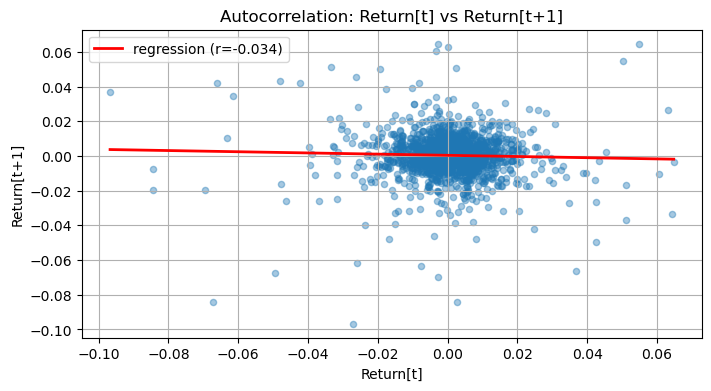

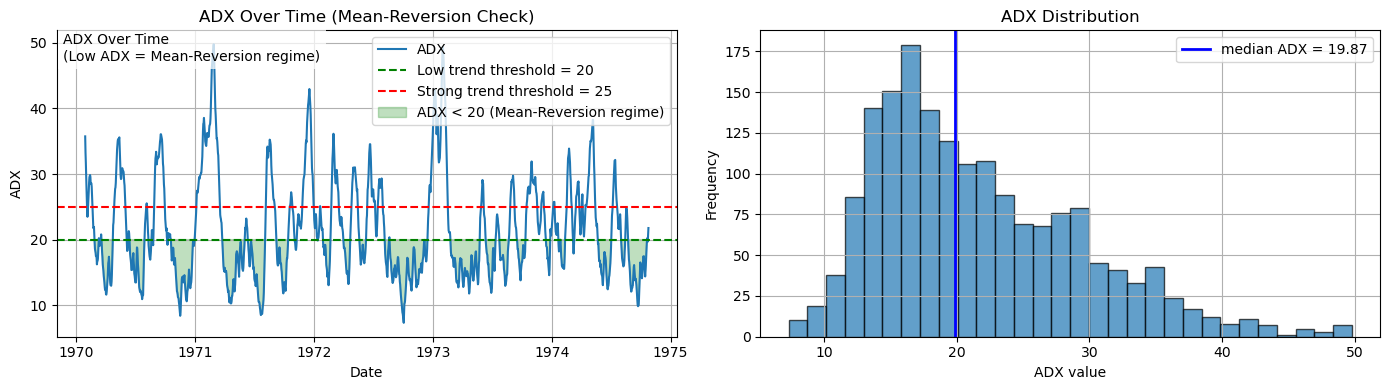

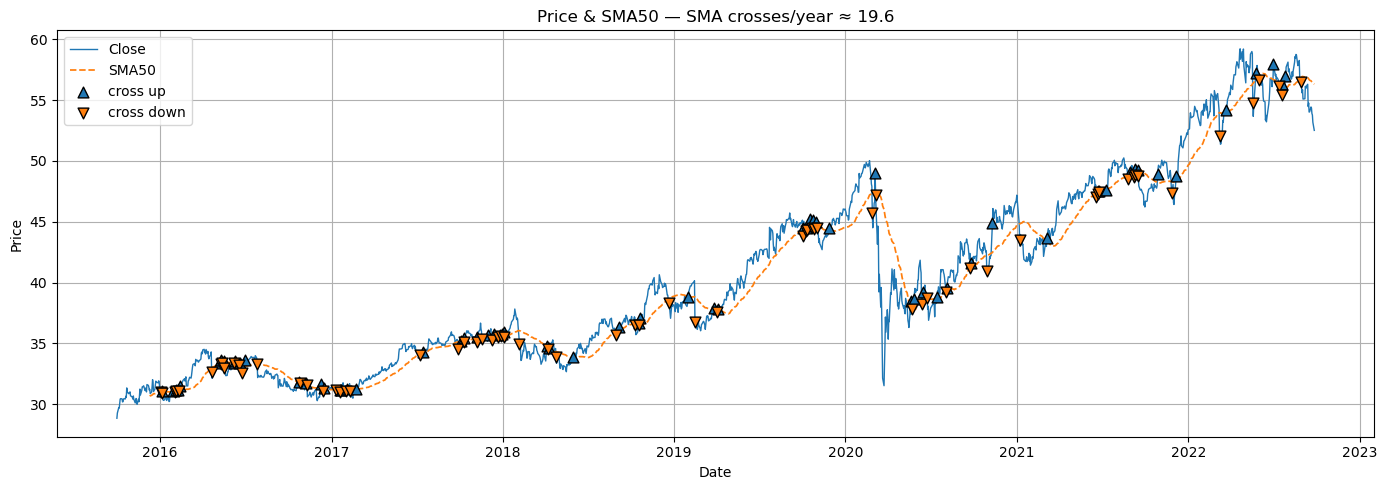

                         date  type      price        sma
0   2016-01-04 05:00:00+00:00  down  30.964712  31.066640
1   2016-01-05 05:00:00+00:00    up  31.074257  31.061368
2   2016-01-06 05:00:00+00:00  down  30.906284  31.059260
3   2016-01-28 05:00:00+00:00    up  31.088858  31.066274
4   2016-02-02 05:00:00+00:00  down  30.993929  31.116055
..                        ...   ...        ...        ...
128 2022-07-13 04:00:00+00:00  down  56.187283  56.402891
129 2022-07-19 04:00:00+00:00    up  56.322392  56.306275
130 2022-07-20 04:00:00+00:00  down  55.394646  56.256274
131 2022-07-26 04:00:00+00:00    up  56.934879  56.125788
132 2022-08-29 04:00:00+00:00  down  56.502537  56.852919

[133 rows x 4 columns]


In [32]:
# # Kiểm tra cổ phiếu có pattern mean-reversion không

res = check_mean_reversion(df)
for k, v in res.items():
    print(f"{k}: {v}")

# Trực quan hóa

plot_autocorrelation(df)
plot_adx_mr(df)

df_re = compute_indicators_mean_reversion(df)   
crosses = plot_price_with_sma_crosses(df_re, sma_window=50)
print(crosses)



### Nhận xét:

- autocorr = -0.03437 < 0 : cho thấy returns có khuynh hướng đảo chiều nhẹ, không có sự nối tiếp rõ rệt.
  
- adx_median = 19.86539 => ADX trung vị gần 20, chứng tỏ xu hướng thị trường yếu, không bền vững..

- total_crosses_per_year: 19.6 => nghĩa là trung bình khoảng 1 lần cắt mỗi ~12–13 ngày giao dịch, có hơi hướng biến động ngắn hạn.

**Kết luận:** 

Cổ phiếu Coca-Cola có một số dấu hiệu mean-reversion nhưng không quá mạnh



## Phân tích Calendar Effect 
Tìm hiểu xem giá cổ phiếu có xu hướng tăng/giảm khác nhau theo thời gian cố định không ?



1. PHÂN TÍCH THEO THÁNG (MONTH EFFECT)
📊 Trung bình Return theo tháng:
 Month Month_Name  Avg_Return  Std_Dev  Total_Days
     7       July    0.146556 1.044819         146
    12   December    0.135737 0.933122         147
    10    October    0.112506 0.900513         153
     4      April    0.095958 1.408773         144
     3      March    0.061271 2.099509         155
     5        May    0.051936 1.195932         148
     6       June    0.033569 1.082401         150
    11   November    0.033086 1.135280         144
     1    January    0.010652 0.990294         141
     8     August   -0.007192 0.761036         157
     9  September   -0.064213 1.022961         139
     2   February   -0.133931 1.371571         134
✓ Tháng tốt nhất: 7 (July) - Avg 0.1466%
✗ Tháng tồi nhất: 2 (February) - Avg -0.1339%
  Chênh lệch: 0.2805%
2. PHÂN TÍCH THEO QUÝ (QUARTER EFFECT)
📊 Trung bình Return theo quý:
Quarter  Avg_Return  Std_Dev  Total_Days
     Q4    0.094440 0.991539         444
     Q

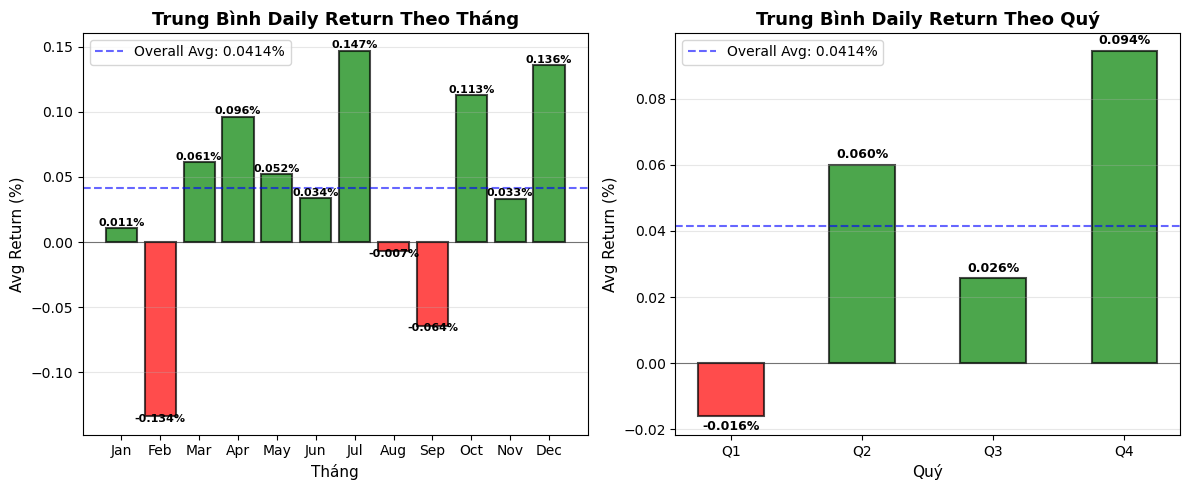

In [33]:
results = analyze_calendar_effects(df)

**Nhận xét kết quả** 

**1. Month Effect**

- Tháng 7, 10 và 12 có daily return trung bình cao vượt trội, cao hơn rõ rệt mức trung bình toàn thị trường (~0.041%).

- Tháng 2 là tháng kém nhất, daily return trung bình âm sâu → rủi ro giảm giá cao.

- Một số tháng có return dương nhưng không vượt trung bình chung (Jan, Jun, Nov) → hiệu ứng yếu.

**2. Quarter Effect**

- Q4 và Q2 là những quý có daily return trung bình cao nhất
  
- Q1 có daily return âm, cho thấy xu hướng kém hiệu quả

**Kết luận chung**

- Đầu năm, công ty Coca cola có xu hướng tăng trưởng yếu. Nguyên nhân có thể do đầu năm, sau một mùa đông/sau tết thì nhu cầu tiêu thụ giảm -> Giá cổ phiếu yếu
  
- Từ tháng 3-7 là giai đoạn chuyển giao mùa hè, nên nhu cầu đồ uống tăng cao -> Công ty kinh doanh tốt -> giá cổ phiếu mạnh

- Từ tháng 10-12 là giai đoán gắn với mùa lễ hội (Tết, Giáng Sinh), có thể nhờ có các chiến lược marketing tốt gắn với chủ dề mùa đông, lễ tết nên thu hút được nhiều người tiêu dùng -> giá cổ phiếu tăng ổn định và mạnh.


## Phân tích Pattern Up Down

Tìm hiểu xem thị trường có xu hướng tăng nhẹ nhiều ngày hay giảm mạnh ít ngày?


=== Up/Down Pattern Summary ===

Total days analyzed: 1758

Metric       |         Up |       Down
------------------------------------
count        |        449 |        446
mean         |       2.09 |       1.81
median       |       2.00 |       1.00
max          |         10 |          8

Transition probabilities (rows=Prev state, cols=Curr state) in %:
Daily_Return     -1      1
Daily_Return              
-1.0          44.84  55.16
 1.0          47.39  52.61



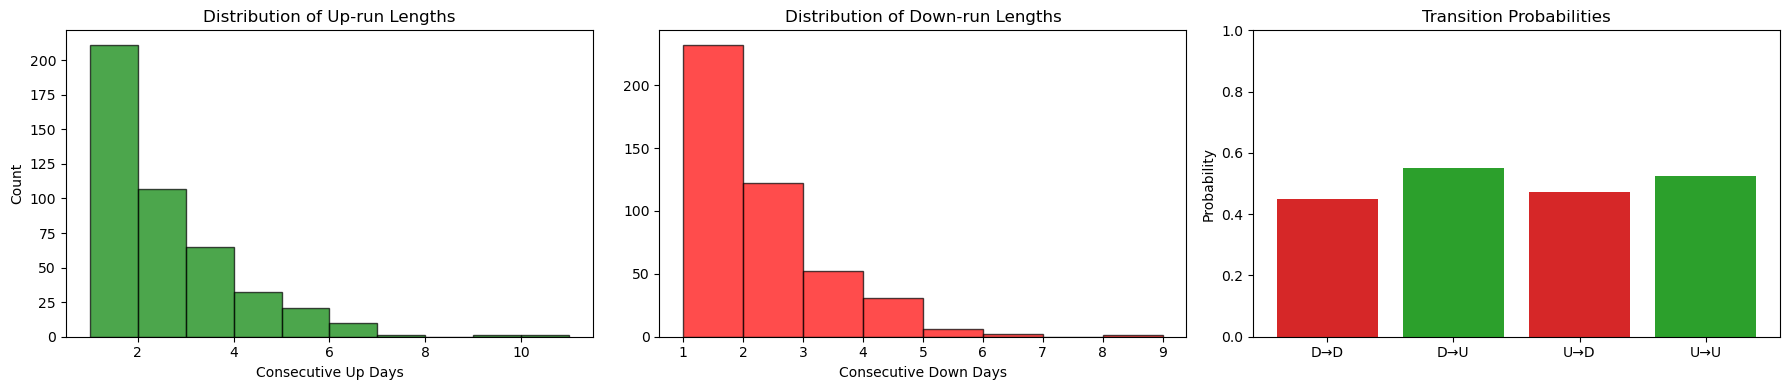

In [34]:
results_up_down = analyze_up_down(df)

**Nhận xét kết quả phân tích Up-down**

**Phân bố chuỗi ngày tăng/giảm**

- Chuỗi tăng/giảm phổ biến nhất là 2 ngày, cho thấy thị trường thường có những đợt tăng/giảm ngắn hạn.

- Tần suất giảm dần khi số ngày tăng/giảm liên tiếp tăng lên, phản ánh rằng các chuỗi tăng/giảm dài hạn là hiếm.

Nhìn chung, cổ phiếu Coca-Cola không có xu hướng tăng hoặc giảm trong dài ngày.

**Xác suất chuyển trạng thái**

- D → U = 55.16%

→ Sau khi giảm, giá có xác suất hồi phục khá cao (>55%). Điều này thể hiện đặc tính mean-reversion nhẹ.

- U → U = 52.61%

→ Khi đã tăng, giá vẫn có xu hướng tiếp tục duy trì đà tăng, nhưng xác suất chỉ hơi nhỉnh hơn 50%.

- Cả hai xác suất (D→U và U→U) đều chỉ hơi lệch khỏi 50%.

→ Điều này cho thấy hành vi giá không thiên mạnh về trend-following, nhưng có dấu hiệu mean-reversion nhẹ, chủ yếu thể hiện ở giai đoạn sau khi giảm

**Kết luận**

Từ kết quả trên có thể rút ra:

- KO không phải cổ phiếu có xu hướng mạnh (trend-following yếu).

- Có mean-reversion nhẹ, thể hiện ở khả năng hồi phục sau khi giảm.

- Độ dài các chuỗi cho thấy giảm thường ngắn, còn tăng duy trì lâu hơn một chút, nhưng không ở mức quá rõ rệt.


## Nhận xét tổng quát

Cổ phiếu Coca-Cola hiện không có trend mạnh (ADX thấp, autocorr âm), nhưng thể hiện mean-reversion yếu và có một số hiệu ứng mùa vụ (Q2/Q4, tháng 7/10/12 tốt; tháng 2 yếu). 


# Chiến lược giao dịch

Dựa trên phân tích đặc tính vận động của cổ phiếu Coca-Cola, ta ghi nhận một số điểm quan trọng:

- Không có xu hướng mạnh: ADX thấp và autocorrelation âm cho thấy giá không duy trì trend dài hạn; do đó các chiến lược trend-following kém hiệu quả.

- Mean-reversion tồn tại nhưng yếu: Giá có xu hướng hồi phục nhẹ sau các biến động ngắn hạn, nhưng không đủ mạnh để xây dựng chiến lược MR độc lập.

- Mùa vụ rõ rệt: Hiệu ứng lịch thể hiện khá ổn định — cổ phiếu thường mạnh vào Q2, Q4, đặc biệt các tháng 7 / 10 / 12, trong khi tháng 2 thường yếu.

Từ các quan sát này, ta quyết định ưu tiên một chiến lược mùa vụ ngắn hạn thay vì MR hoặc trend.


## Chiến lược giao dịch dựa trên Pattern seasonality

Chiến lược này chỉ hoạt động trong 2 giai đoạn: Tháng 3 - Tháng 7 và Tháng 10 - Tháng 12

**1. Mua Ban Đầu (Entry)**

- Thời điểm: Ngày giao dịch đầu tiên của tháng (ví dụ: ngày 1/3, 1/10).
  
- Hành động: MUA tại Giá Mở Cửa (OPEN).

**2. Chu Kỳ Thoát/Vào Lại (Buy-Sell Cycle)**

Mỗi ngày, hãy kiểm tra Giá Đóng Cửa (CLOSE) so với Giá Mua Ban Đầu (Entry Price) của vị thế hiện tại:

- Nếu Lời $\ge 5\%$ HOẶC Lỗ $\le -5\%$:
  
    - BÁN tại Giá Mở Cửa (OPEN) của NGÀY HÔM SAU.
      
    - Sau đó, MUA LẠI ngay tại Giá Đóng Cửa (CLOSE) của chính ngày bán đó.

**3. Kết Thúc Giai Đoạn (Exit)**

- Thời điểm: Ngày giao dịch cuối cùng của tháng 7 hoặc tháng 12.
  
- Hành động: Luôn BÁN tại Giá Mở Cửa (OPEN) của ngày cuối cùng đó để kết thúc vị thế và chờ đợi mùa giao dịch tiếp theo

## Backtest trên tập train

            entry_date           exit_date  entry_price  exit_price  shares  \
0  2015-10-01 04:00:00 2015-10-21 04:00:00    29.149118   30.395662    3430   
1  2015-10-21 04:00:00 2015-12-31 05:00:00    30.576847   31.621973    3409   
2  2016-03-01 05:00:00 2016-03-14 04:00:00    31.680395   33.149215    3402   
3  2016-03-14 04:00:00 2016-07-29 04:00:00    33.333214   32.424467    3383   
4  2016-10-03 04:00:00 2016-12-30 05:00:00    31.635122   31.435078    3467   
5  2017-03-01 05:00:00 2017-05-09 04:00:00    31.676353   33.386008    3440   
6  2017-05-09 04:00:00 2017-06-02 04:00:00    33.096951   34.861725    3470   
7  2017-06-02 04:00:00 2017-07-31 04:00:00    34.907364   35.278994    3465   
8  2017-10-02 04:00:00 2017-11-15 05:00:00    34.825328   36.580119    3510   
9  2017-11-15 05:00:00 2017-12-29 05:00:00    36.185871   35.617433    3548   
10 2018-03-01 05:00:00 2018-04-18 04:00:00    33.591052   35.302854    3762   
11 2018-04-18 04:00:00 2018-05-03 04:00:00    34.996

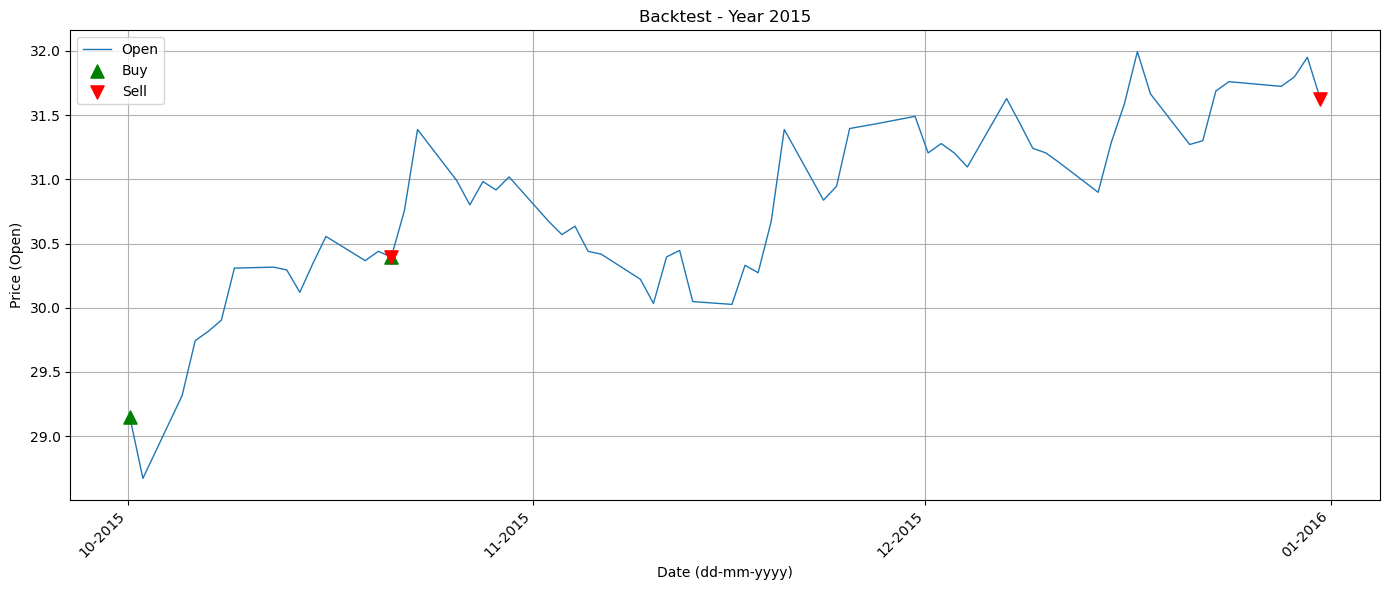

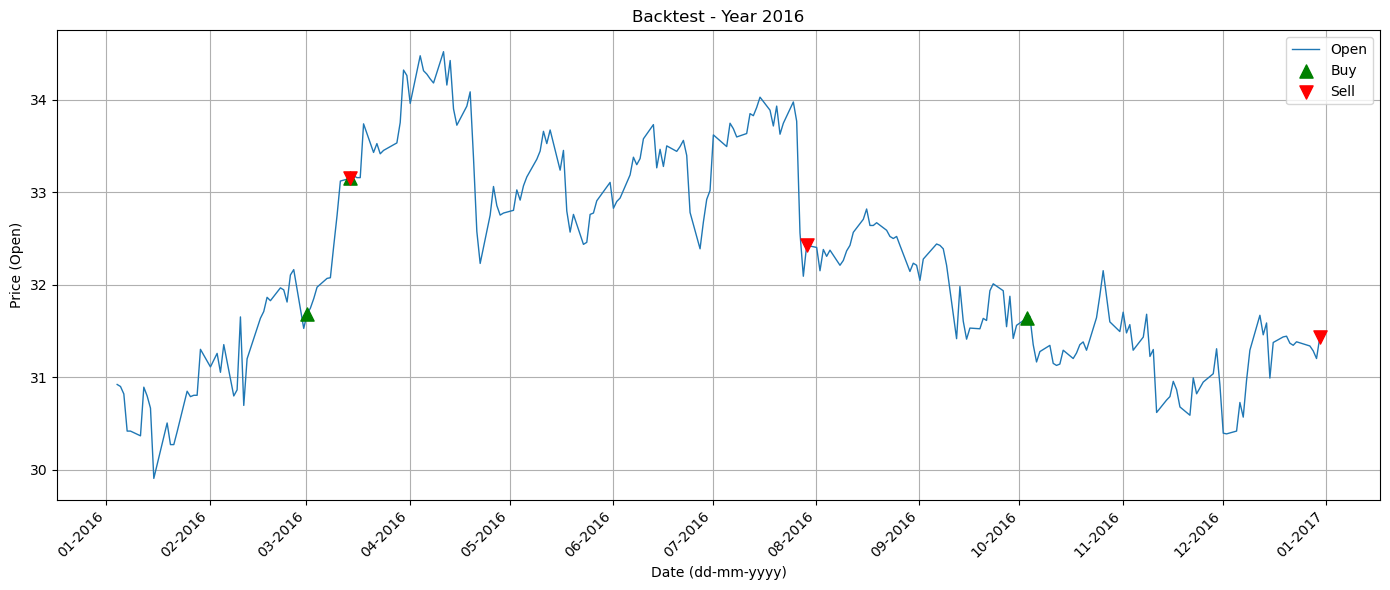

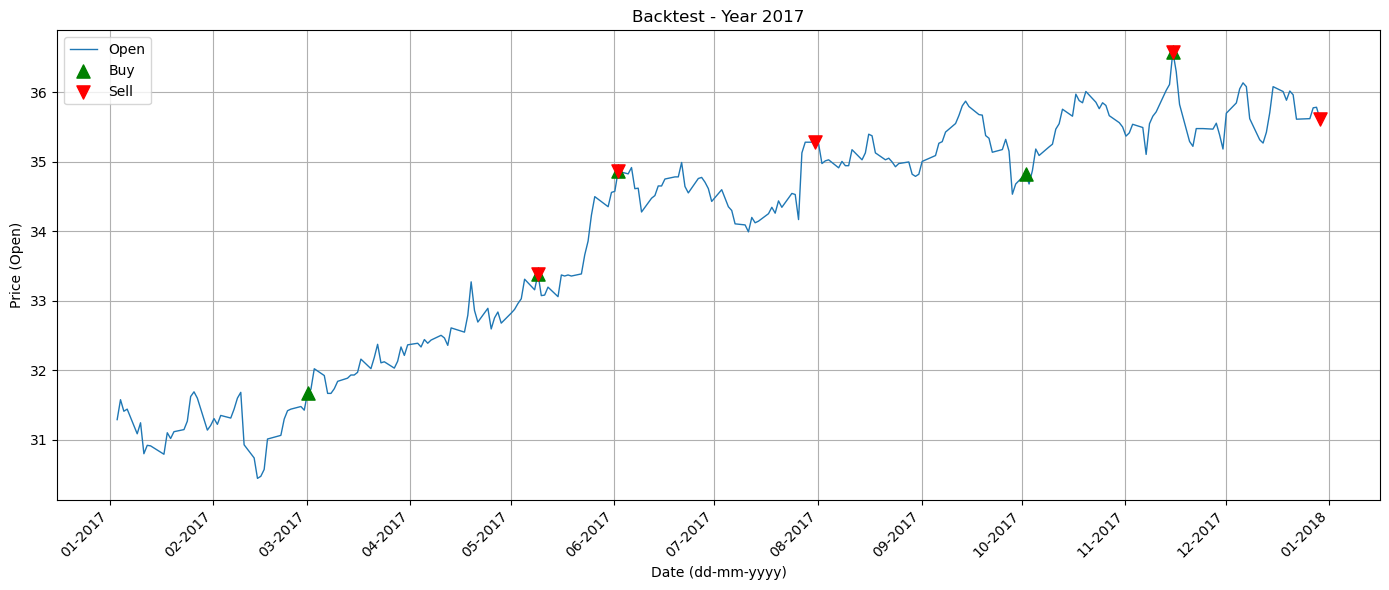

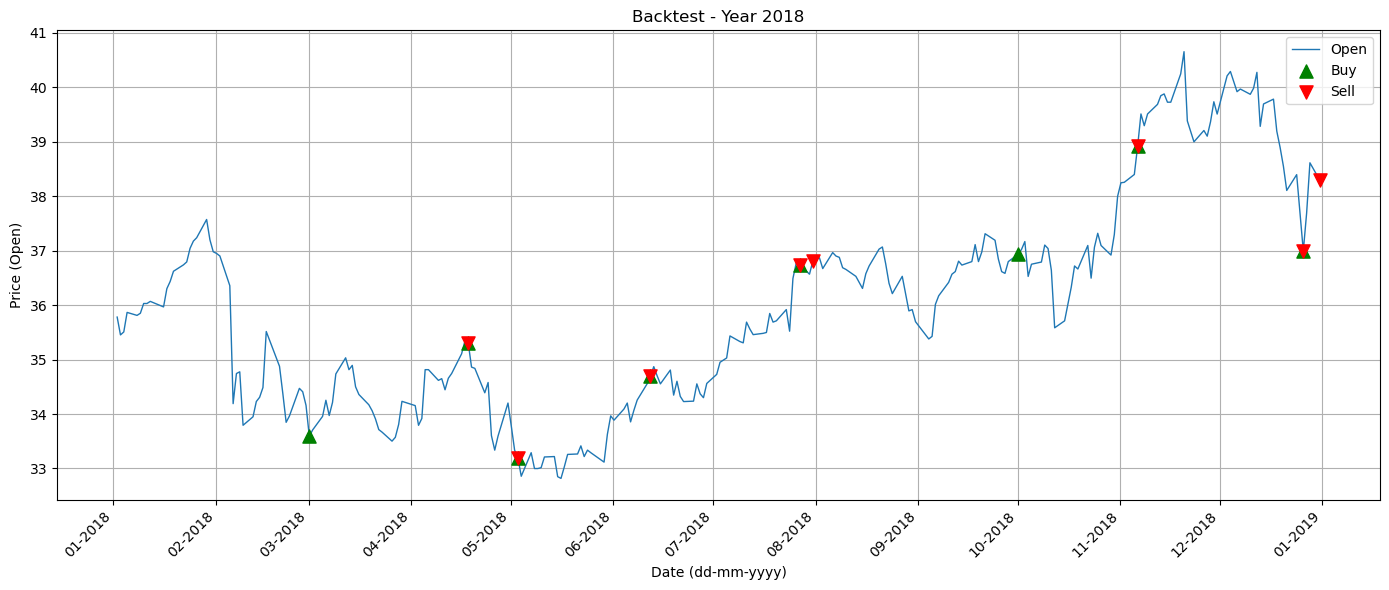

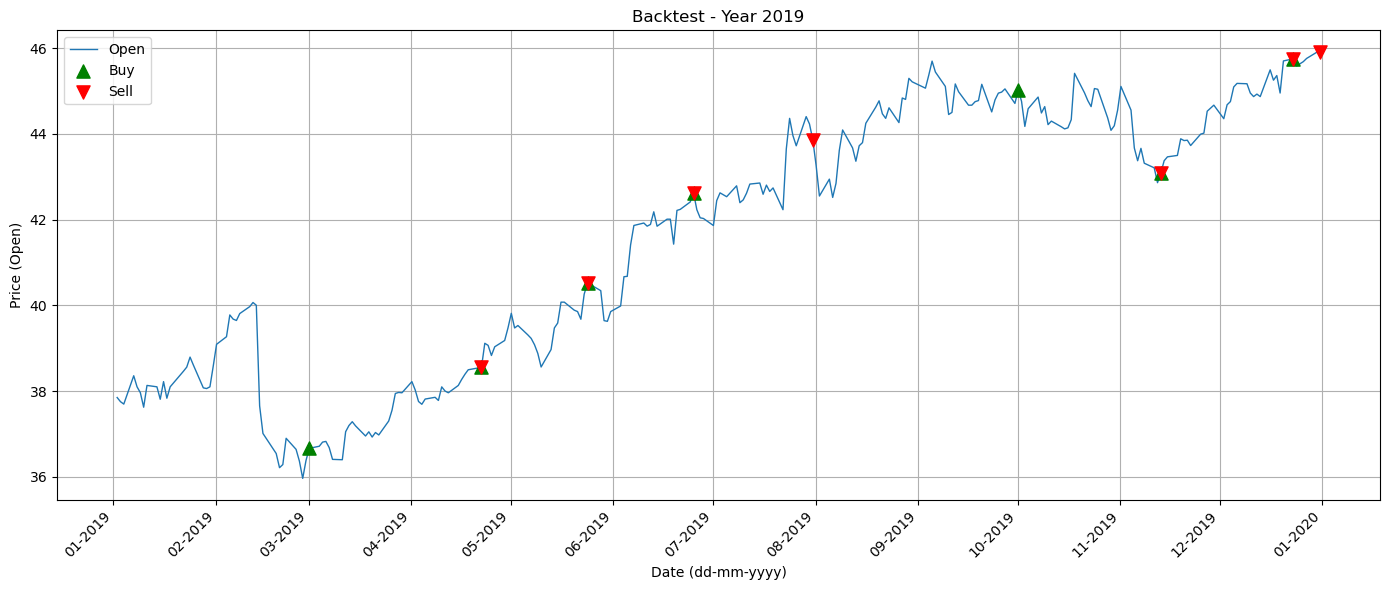

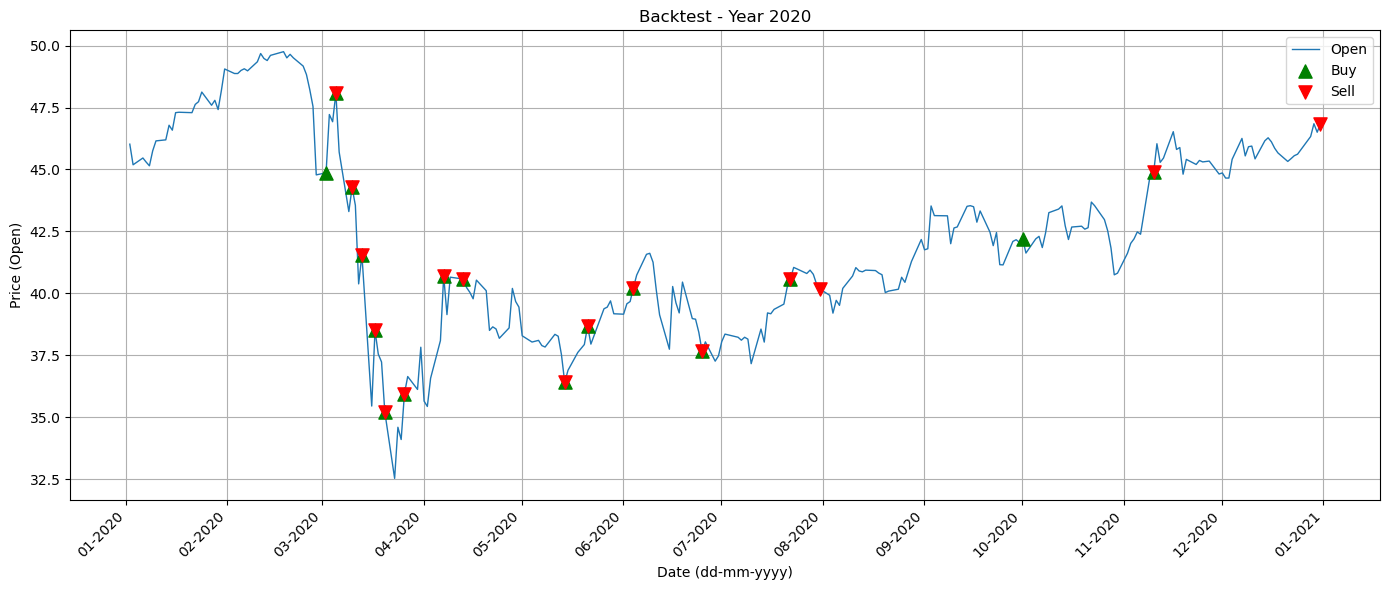

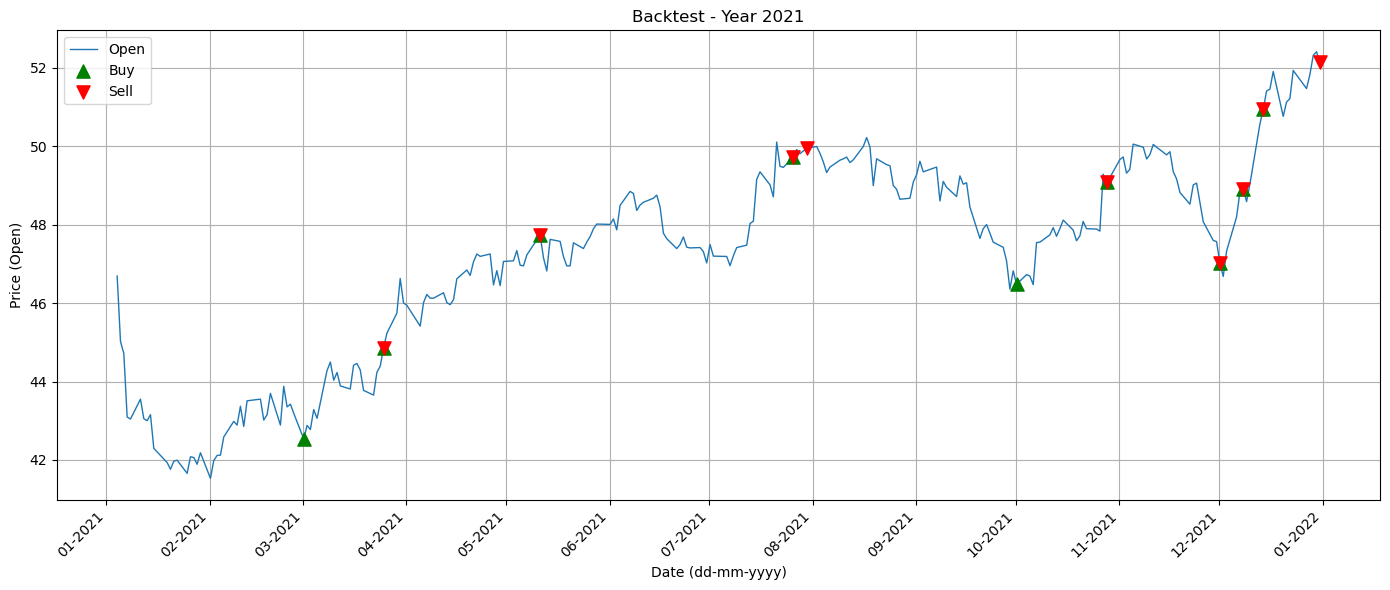

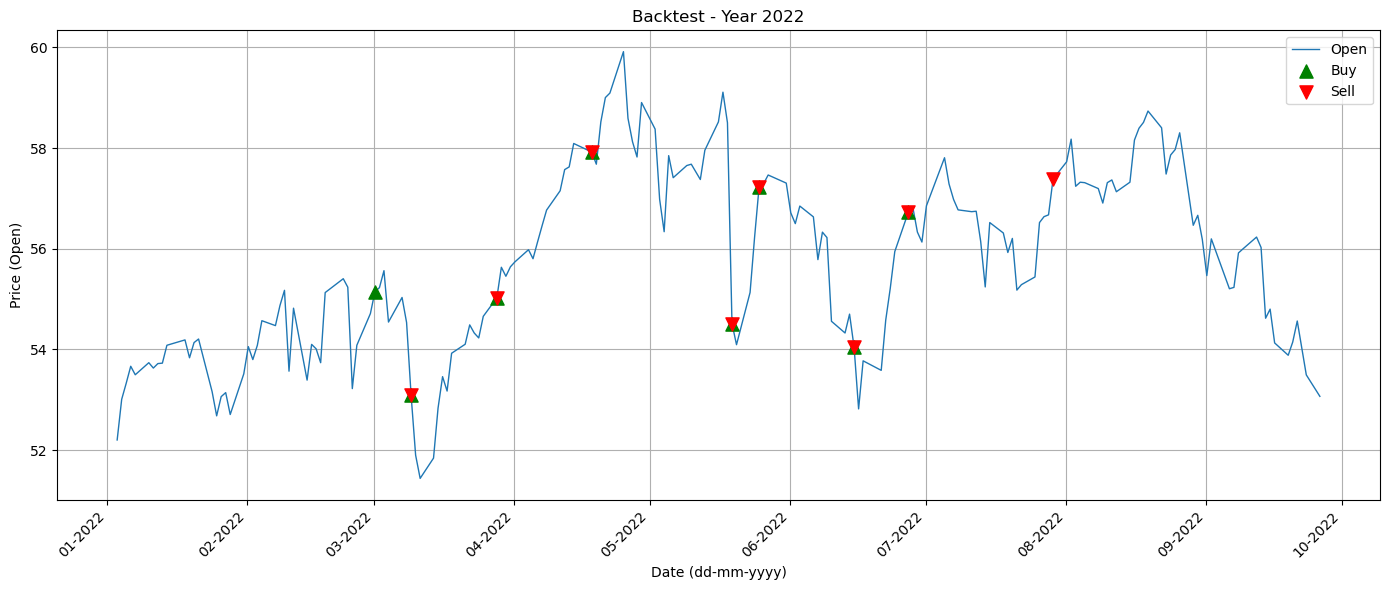

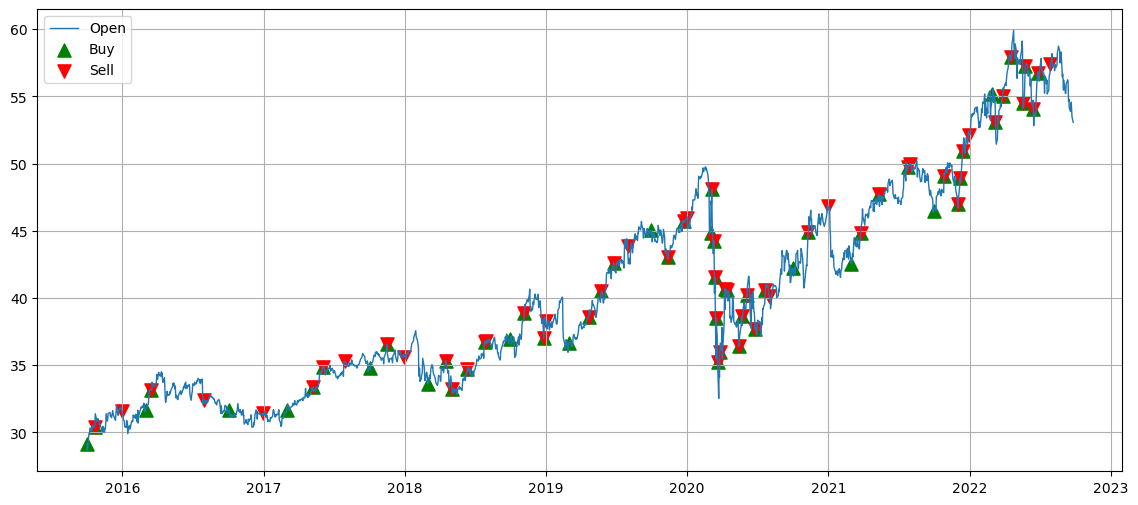

In [35]:

# Gọi backtest
trades_df = run_strategy(df, initial_capital=100000, stop_loss=-0.05, take_profit=0.05)

# Kiểm tra kết quả
print(trades_df.head(20))
print("Total trades:", len(trades_df))
if not trades_df.empty:
    print("Final capital (last trade):", trades_df['capital_after'].iloc[-1])
    print("Cumulative return % (approx):", (trades_df['capital_after'].iloc[-1] / 100000 - 1) * 100)

# Trực quan lịch sử giao dịch
plot_trades_by_year(df, trades_df)
plot_trades(df, trades_df)


In [36]:
trades_df.head(10)

,entry_date,exit_date,entry_price,exit_price,shares,return_pct,capital_after,reason
0,2015-10-01 04:00:00,2015-10-21 04:00:00,29.149118,30.395662,3430,4.276438,104257.119551,TP
1,2015-10-21 04:00:00,2015-12-31 05:00:00,30.576847,31.621973,3409,3.418029,107799.304446,period_end
2,2016-03-01 05:00:00,2016-03-14 04:00:00,31.680395,33.149215,3402,4.636370,112773.629629,TP
3,2016-03-14 04:00:00,2016-07-29 04:00:00,33.333214,32.424467,3383,-2.726250,109691.972075,period_end
4,2016-10-03 04:00:00,2016-12-30 05:00:00,31.635122,31.435078,3467,-0.632346,108985.415682,period_end
5,2017-03-01 05:00:00,2017-05-09 04:00:00,31.676353,33.386008,3440,5.397258,114847.866458,TP
6,2017-05-09 04:00:00,2017-06-02 04:00:00,33.096951,34.861725,3470,5.332137,120970.186665,TP
7,2017-06-02 04:00:00,2017-07-31 04:00:00,34.907364,35.278994,3465,1.064617,122241.713374,period_end
8,2017-10-02 04:00:00,2017-11-15 05:00:00,34.825328,36.580119,3510,5.038835,128396.216935,TP
9,2017-11-15 05:00:00,2017-12-29 05:00:00,36.185871,35.617433,3548,-1.570884,126370.653095,period_end


In [37]:
if len(trades_df) > 0:
    print("\n===== TỔNG KẾT =====")
    print(f"Tổng lợi nhuận cộng dồn: {trades_df['return_pct'].sum():.2f}%")
    print(f"Lợi nhuận trung bình mỗi trade: {trades_df['return_pct'].mean():.2f}%")
    print(f"Win rate: {(trades_df['return_pct'] > 0).mean() * 100:.2f}%")
else:
    print("Không có trade nào được tạo.")


===== TỔNG KẾT =====
Tổng lợi nhuận cộng dồn: 107.86%
Lợi nhuận trung bình mỗi trade: 1.86%
Win rate: 70.69%


## Backtest trên tập test

            entry_date           exit_date  entry_price  exit_price  shares  \
0  2022-10-03 04:00:00 2022-10-27 04:00:00    51.135036   54.228895    1955   
1  2022-10-27 04:00:00 2022-11-25 05:00:00    54.011143   56.914485    1962   
2  2022-11-25 05:00:00 2022-12-30 05:00:00    56.878193   58.405469    1963   
3  2023-03-01 05:00:00 2023-03-30 04:00:00    54.028712   56.975169    2122   
4  2023-03-30 04:00:00 2023-07-31 04:00:00    56.947544   57.937901    2123   
5  2023-10-02 04:00:00 2023-10-06 04:00:00    52.281953   48.663081    2352   
6  2023-10-06 04:00:00 2023-10-26 04:00:00    49.691700   52.712104    2303   
7  2023-10-26 04:00:00 2023-11-27 05:00:00    52.160389   54.741291    2327   
8  2023-11-27 05:00:00 2023-12-29 05:00:00    54.666481   55.365685    2330   
9  2024-03-01 05:00:00 2024-05-08 04:00:00    56.459050   59.713421    2284   
10 2024-05-08 04:00:00 2024-07-25 04:00:00    59.713421   63.231073    2284   
11 2024-07-25 04:00:00 2024-07-31 04:00:00    63.259

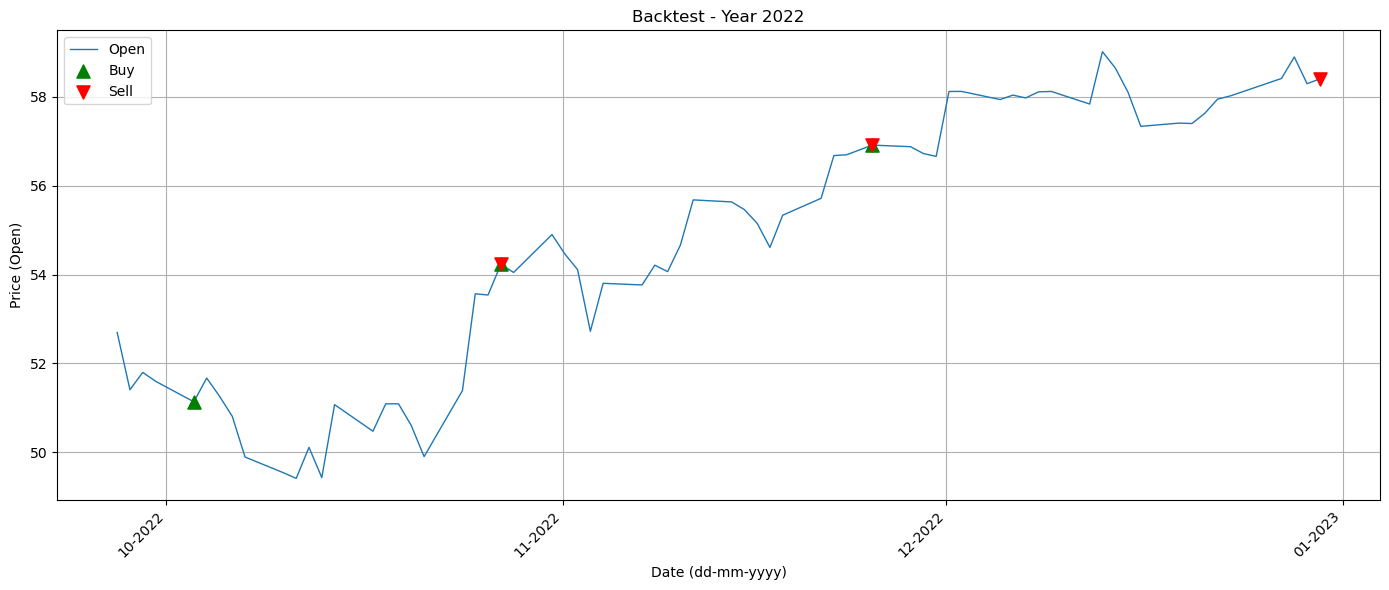

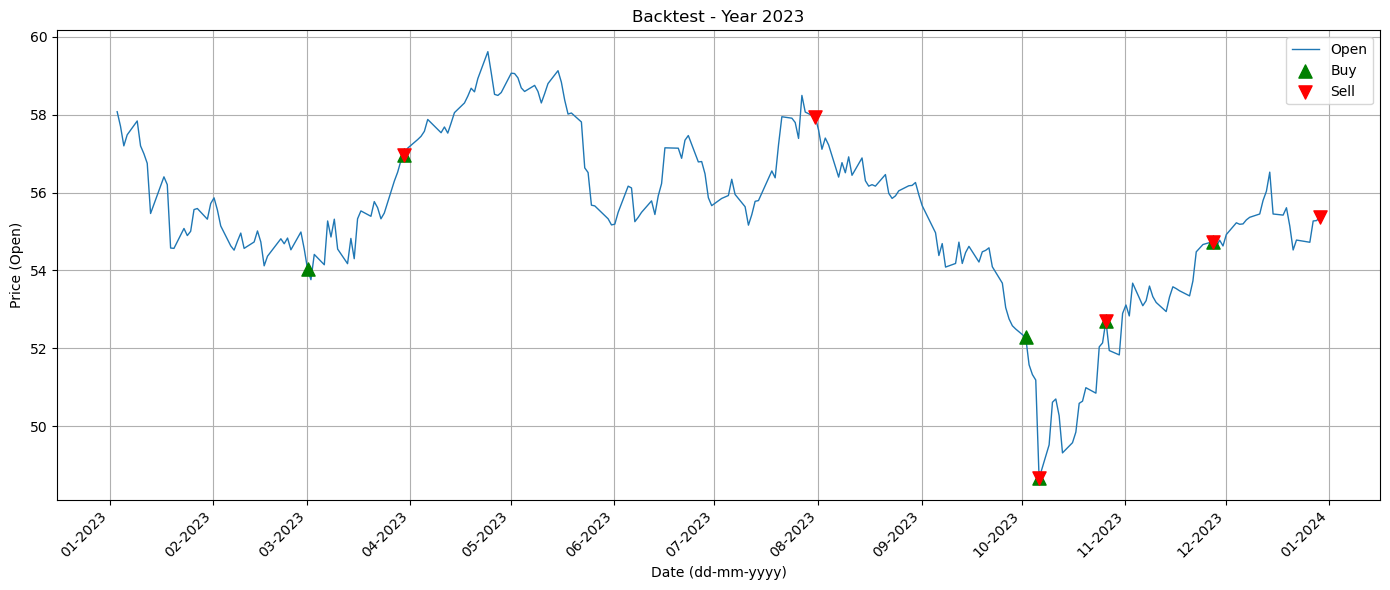

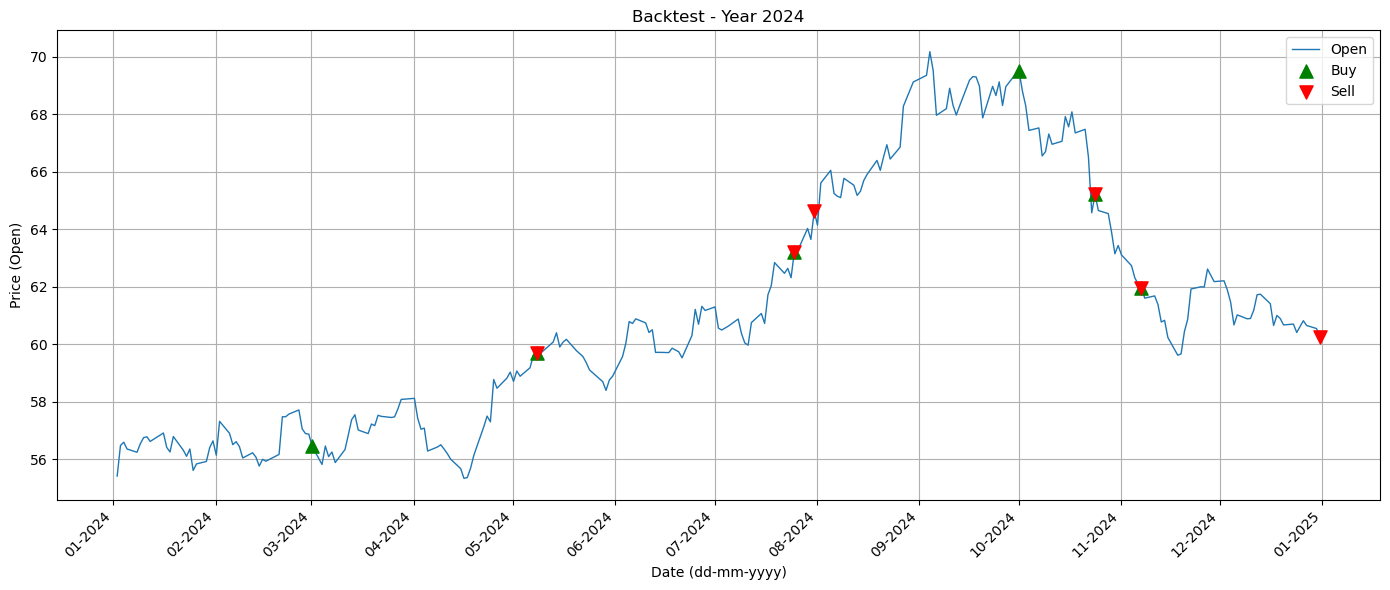

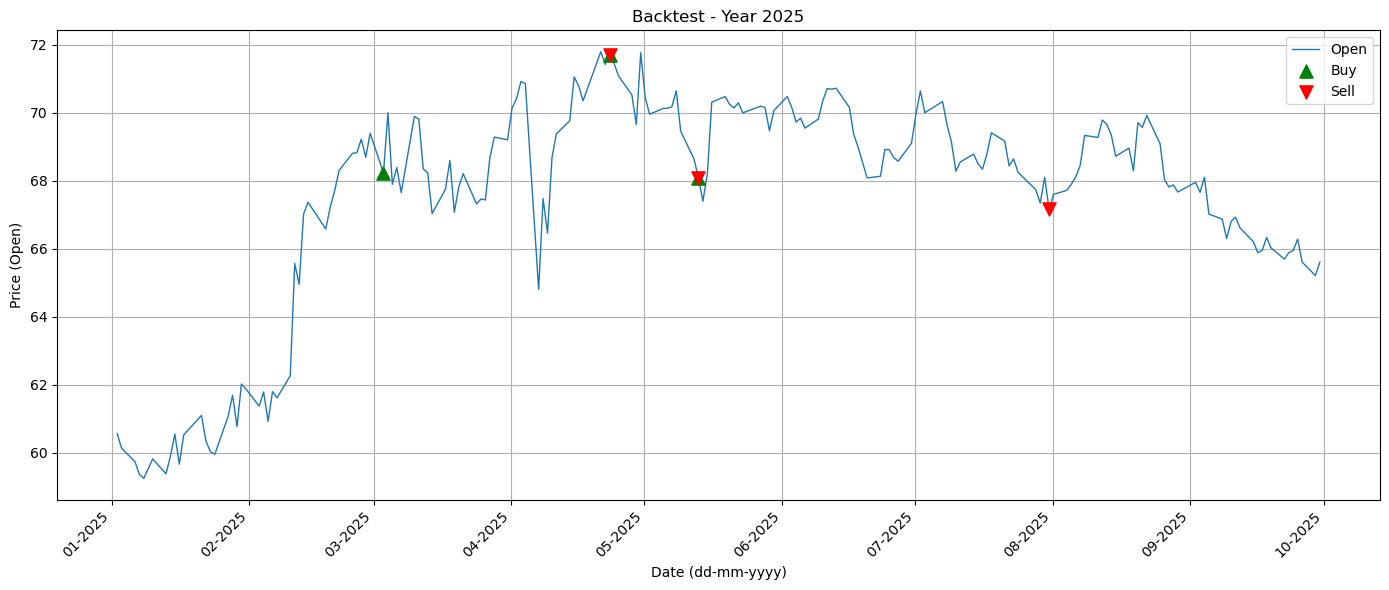

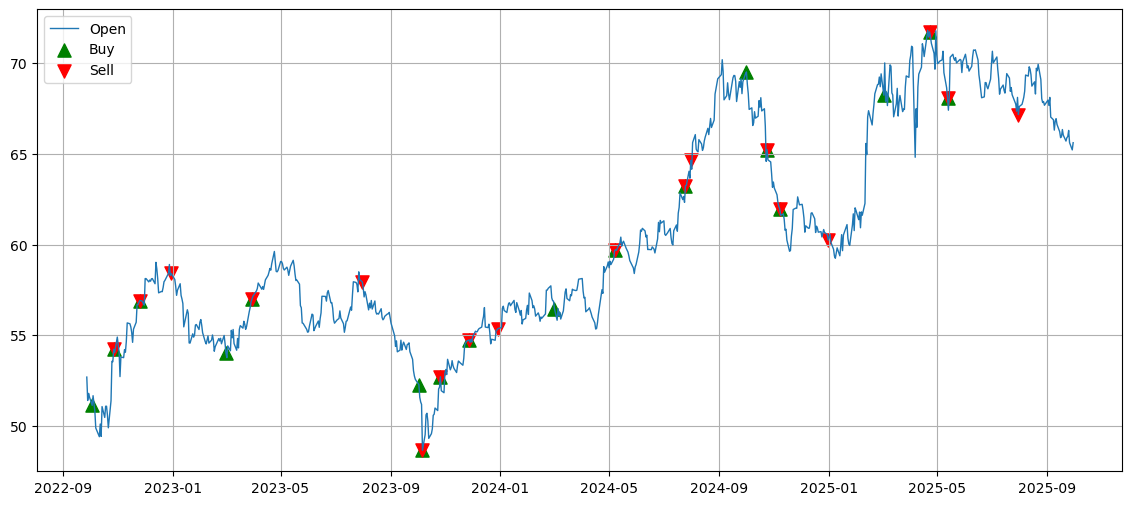

In [38]:

# Gọi backtest
trades_df_val = run_strategy(df_val, initial_capital=100000, stop_loss=-0.05, take_profit=0.05)

# Kiểm tra kết quả
print(trades_df_val.head(20))
print("Total trades:", len(trades_df_val))
if not trades_df_val.empty:
    print("Final capital (last trade):", trades_df_val['capital_after'].iloc[-1])
    print("Cumulative return % (approx):", (trades_df_val['capital_after'].iloc[-1] / 100000 - 1) * 100)

# Trực quan lịch sử giao dịch
plot_trades_by_year(df_val, trades_df_val)
plot_trades(df_val, trades_df_val)

In [39]:
trades_df_val.head(10)

,entry_date,exit_date,entry_price,exit_price,shares,return_pct,capital_after,reason
0,2022-10-03 04:00:00,2022-10-27 04:00:00,51.135036,54.228895,1955,6.050370,106017.488825,TP
1,2022-10-27 04:00:00,2022-11-25 05:00:00,54.011143,56.914485,1962,5.375451,111666.220452,TP
2,2022-11-25 05:00:00,2022-12-30 05:00:00,56.878193,58.405469,1963,2.685169,114649.934874,period_end
3,2023-03-01 05:00:00,2023-03-30 04:00:00,54.028712,56.975169,2122,5.453501,120901.307722,TP
4,2023-03-30 04:00:00,2023-07-31 04:00:00,56.947544,57.937901,2123,1.739068,123002.163261,period_end
5,2023-10-02 04:00:00,2023-10-06 04:00:00,52.281953,48.663081,2352,-6.921838,114455.567304,SL
6,2023-10-06 04:00:00,2023-10-26 04:00:00,49.691700,52.712104,2303,6.078286,121395.974374,TP
7,2023-10-26 04:00:00,2023-11-27 05:00:00,52.160389,54.741291,2327,4.948012,127382.985236,TP
8,2023-11-27 05:00:00,2023-12-29 05:00:00,54.666481,55.365685,2330,1.279036,129002.046335,period_end
9,2024-03-01 05:00:00,2024-05-08 04:00:00,56.459050,59.713421,2284,5.764126,136385.453262,TP


In [40]:
if len(trades_df_val) > 0:
    print("\n===== TỔNG KẾT =====")
    print(f"Tổng lợi nhuận cộng dồn: {trades_df_val['return_pct'].sum():.2f}%")
    print(f"Lợi nhuận trung bình mỗi trade: {trades_df_val['return_pct'].mean():.2f}%")
    print(f"Win rate: {(trades_df_val['return_pct'] > 0).mean() * 100:.2f}%")
else:
    print("Không có trade nào được tạo.")


===== TỔNG KẾT =====
Tổng lợi nhuận cộng dồn: 27.60%
Lợi nhuận trung bình mỗi trade: 1.53%
Win rate: 66.67%


## Nhận xét chiến lược

- Nếu xét lợi nhuận trung bình mỗi trade và win rate thì chênh lệch train và validation không quá lớn. Riêng tổng lợi nhuận cộng dồn thì có sự chênh lệch nhưng có thể tập validation nhỏ hơn tập train nên chưa giao dịch đủ nhiều để kiếm lợi nhuận. Việc kết quả tập train và validation gần giống nhau có thể là do chiến lược của ta ít tối ưu tham số nên nguy cơ overfitting khá thấp.

- Dù kết quả cho thấy chiến lược hoạt động tốt trên cả tập train và validation. Nhưng nó vẫn có một số nhược điểm:

    - Phụ thuộc vào mùa vụ, nếu chu kỳ thay đổi thì hiệu quả sẽ giảm rõ rệt
      
    - Tần suất giao dịch thấp, nên chỉ cần vài tháng tệ thì hiệu quả cả năm bị ảnh hưởng

